# Navier Stokes For Incomprensible Fluid Flow On A Square Cavity


Before introducing the Navier-Stokes (N-S) equations, let's discuss the assumptions we have made:

1. Newtonian fluid: The viscosity of the fluid, denoted by $\eta$, is directly proportional to the shearing stress $\sigma_{xy}$ caused by the viscosity, in relation to the velocity gradient $\nabla_{y}v_{x}$.

2. Isotropic: The pressure is uniformly applied in all directions, represented by $\nabla_{ij}=p\delta_{ij}$, where $\delta_{ij}$ is the Kronecker Delta.

3. Homogeneous fluid flow: The fluid density $\rho$ and viscosity $\eta$ are constant throughout the flow, indicated by $\rho=cte$ and $\eta=cte$.

4. Incompressible fluid flow: The divergence of the velocity vector $\nabla v$ is zero.

Now we can write the Navier-Stokes equations:

The first equation describes the momentum conservation:

$$\frac{\partial v}{\partial t} + ((v\nabla)v)=-\frac{1}{\rho}\nabla p + \nu\nabla v$$

Here, $\nu$ represents the kinematic viscosity, defined as $\nu=\frac{\eta}{\rho}$.

The second equation represents mass conservation for incompressible flow:

$$\nabla v = 0$$

In incompressible flow, the mass conservation equation imposes a kinematic constraint that requires the pressure field to evolve in such a way that the rate of expansion $\nabla v = 0$ vanishes everywhere. To overcome this issue, we can construct a pressure field that ensures mass conservation. This can be achieved by taking the divergence of the momentum equation, resulting in a Poisson equation for the pressure:

$$\nabla^{2} p = -\rho \nabla ((v \nabla)v)$$

Our objective is to solve these three equations in two dimensions. The momentum and pressure equations can be written as:

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x} + \nu \left(\frac{\partial^{2} u}{\partial x^{2}} + \frac{\partial^{2} u}{\partial y^{2}}\right)$$

$$\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y} + \nu \left(\frac{\partial^{2} v}{\partial x^{2}} + \frac{\partial^{2} v}{\partial y^{2}}\right)$$

$$\frac{\partial^{2} p}{\partial x^{2}} + \frac{\partial^{2} p}{\partial y^{2}} = -\rho \left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x} + 2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x} + \frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\right)$$


To begin the discretization of these three equations using finite elements, we need to import the necessary Python modules for the computation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

Now we generate the physical constants:

In [2]:
rho = 1          # kg·m^-3
eta = 1          # kg·m^−1·s^−1
nu  = 0.5 # m^2·s^-1

And we also define the meshing constants:

In [3]:
Mx = 41           # Mesh quantity in x direction
My = 41           # M esh quantity in y direction
Lx = 2            # Distance in x direction of the cavity in meters
Ly = 2            # Distance in y direction of the cavity in meters
nx = (Mx - 1) / 2 # For the velocity in the middle of the cavity
ny = (My - 1) / 2 # For the velocity in the middle of the cavity

We generate the grid points of the cavity

In [4]:
x   = np.linspace(0, Lx, Mx) # Generate x points with the same spacing
y   = np.linspace(0, Ly, My) # Generate y points with the same spacing
X,Y = np.meshgrid(x, y)      # We generate the mesh points (for plotting, not computing)

We show the points and the mesh we have generated:

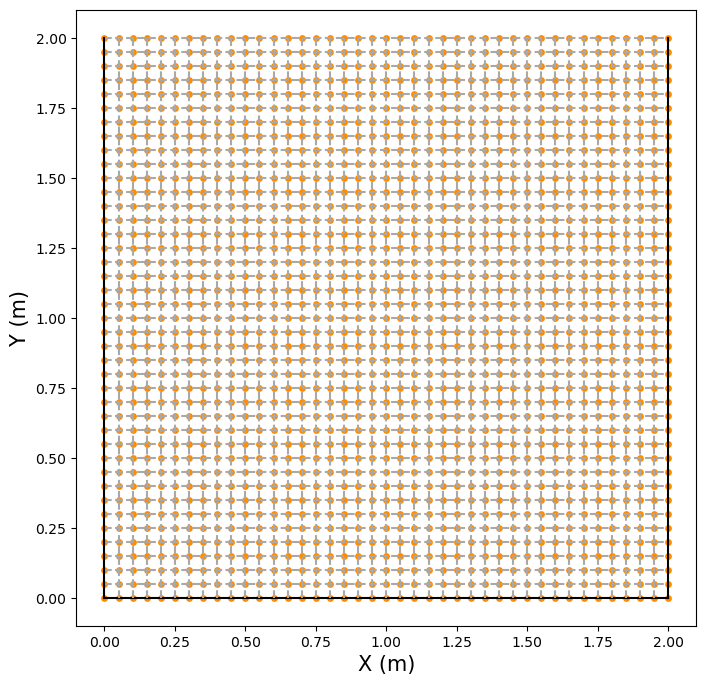

In [18]:
fontsize=15

plt.figure(figsize = (8,8))
plt.xlabel("X (m)", fontsize=fontsize)
plt.ylabel("Y (m)" , fontsize=fontsize)

# Plot the points
plt.scatter (X, Y, s=15, color = "darkorange")

# Plot horizontal dashed lines
for i, yi in enumerate(y):
    linestyle = 'solid' if i == 0 else 'dashed'
    color = 'black' if i == 0 else 'darkgray'
    plt.plot(x, [yi] * len(x), linestyle=linestyle, color=color)

# Plot vertical dashed lines
for i, xi in enumerate(x):
    linestyle = 'solid' if i == 0 or i == Mx-1 else 'dashed'
    color = 'black' if i == 0 or i == Mx-1 else 'darkgray'
    plt.plot([xi] * len(y), y, linestyle=linestyle, color=color)

plt.savefig("CavityMesh.pdf", bbox_inches='tight')

Ones we have generated our mesh and calculation points, we can start using finite elemets to solve the problem. The space and time discretization will be givenby the Eulers backward and forward formulas, respectively. $n$ here represents the time step and $i$ the mesh point in one X direction (same for Y direction, $j$).

$$
\frac{\partial u}{\partial x} = \frac{u(x) - u(x - \Delta x)}{\Delta x} = \frac{u^{n}_{i} - u^{n}_{i-1}}{\Delta t}
$$

In [6]:
deltax = 2 / (Mx -1) # For finite differences
deltay = 2 / (My -1) # For finite differences

$$
\frac{\partial u}{\partial t} = \frac{u(t + \Delta t) - u(t)}{\Delta t}= \frac{u^{n+1} - u^{n}}{\Delta t}
$$

In [8]:
deltat = 0.001 # For finite differences

We make the discretization of the Poisson equation for the pressure (here we make the corrections on the pressure, using the marker and cell method, MAC: Harlow & Welch (1965)):

$$\frac{p_{i+1,j}^{n} -2 p_{i,j}^{n} + p_{i-1,j}^{n}}{\Delta x^{2}} + \frac{p_{i,j+1}^{n} -2 p_{i,j}^{n} + p_{i,j-1}^{n}}{\Delta y^{2}} =$$

$$=\rho \left[\frac{1}{\Delta t} \left(\frac{u_{i+1,j}^{n} - u_{i-1,j}^{n}}{2\Delta x}+\frac{v_{i,j+1}^{n} - v_{i,j-1}^{n}}{2\Delta y}\right)-\frac{u_{i+1,j}^{n} - u_{i-1,j}^{n}}{2\Delta x}\frac{u_{i+1,j}^{n} - u_{i-1,j}^{n}}{2\Delta x}-2\frac{u_{i,j+1}^{n} - u_{i,j-1}^{n}}{2\Delta y}\frac{v_{i+1,j}^{n} - v_{i-1,j}^{n}}{2\Delta x}-\frac{v_{i,j+1}^{n} - v_{i,j-1}^{n}}{2\Delta y}\frac{v_{i,j+1}^{n} - v_{i,j-1}^{n}}{2\Delta y}\right].$$

So solving for $p_{i,j}^{n}$:

$$
p_{i,j}^{n} = \frac{\left(p_{i+1,j}^{n} + p_{i-1,j}^{n}\right) \Delta y^{2} + \left(p_{i,j+1}^{n} + p_{i,j-1}^{n}\right) \Delta x^{2}}{2(\Delta x^{2} + \Delta y^{2})} - \frac{2\Delta x^{2}\Delta y^{2}}{2(\Delta x^{2} + \Delta y^{2})} \times
$$

$$
\times \left[\frac{1}{\Delta t} \left(\frac{u_{i+1,j}^{n} - u_{i-1,j}^{n}}{2\Delta x}+\frac{v_{i,j+1}^{n} - v_{i,j-1}^{n}}{2\Delta y}\right)-\frac{u_{i+1,j}^{n} - u_{i-1,j}^{n}}{2\Delta x}\frac{u_{i+1,j}^{n} - u_{i-1,j}^{n}}{2\Delta x}-2\frac{u_{i,j+1}^{n} - u_{i,j-1}^{n}}{2\Delta y}\frac{v_{i+1,j}^{n} - v_{i-1,j}^{n}}{2\Delta x}-\frac{v_{i,j+1}^{n} - v_{i,j-1}^{n}}{2\Delta y}\frac{v_{i,j+1}^{n} - v_{i,j-1}^{n}}{2\Delta y}\right]
$$

Now we will introduce a function that defines the time evolution of the pressure. Before proceeding, it will be helpful to introduce a supporting function for the entire set of double terms:

In [9]:
def supp(s, rho, deltat, u, v, deltax, deltay):
    
    s[ 1:-1, 1:-1 ] = (rho * (1 / deltat * 
                    ((u[ 1:-1, 2: ] - u[ 1:-1, 0:-2 ]) / 
                     (2 * deltax) + (v[ 2:, 1:-1 ] - v[ 0:-2, 1:-1] ) / (2 * deltay)) -
                    ((u[ 1:-1, 2: ] - u[ 1:-1, 0:-2 ]) / (2 * deltax)) ** 2 -
                      2 * ((u[ 2:, 1:-1 ] - u[ 0:-2, 1:-1 ]) / (2 * deltay) *
                           (v[ 1:-1, 2: ] - v[ 1:-1, 0:-2 ]) / (2 * deltax))-
                          ((v[ 2:, 1:-1 ] - v[ 0:-2, 1:-1 ]) / (2 * deltay)) ** 2))

    return s

def pressure (p, deltax, deltay, s):
    pn  = np.empty_like(p)
    pn  = p.copy()
    nit = 50  # Note the presence of the pseudo-time variable nit. 
              # This sub-iteration in the Poisson calculation helps ensure a divergence-free field.
    for k in range(nit):
        pn = p.copy()
        p[ 1:-1, 1:-1 ] = (((pn[ 1:-1, 2: ] + pn[ 1:-1, 0:-2 ]) * deltay ** 2 + 
                          (pn[ 2:, 1:-1 ] + pn[ 0:-2, 1:-1 ]) * deltax **2) /
                          (2 * (deltax ** 2 + deltay ** 2)) -
                          deltax ** 2 * deltay ** 2 / (2 * (deltax ** 2 + deltay ** 2)) * 
                          s[ 1:-1,1:-1 ])

        p[ :, -1 ] = p[ :, -2 ]  # dp/dx = 0 at x = 2
        p[ 0, : ]  = p[ 1, : ]   # dp/dy = 0 at y = 0
        p[ :, 0 ]  = p[ :, 1 ]   # dp/dx = 0 at x = 0
        p[ -1, : ] = 0           # p = 0 at y = 2
        
    return p

We make the discretization for both velocities:

$$
\frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t} + u_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i-1,j}^{n}}{\Delta x} + v_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i,j-1}^{n}}{\Delta y} = -\frac{1}{\rho}\frac{p_{i+1,j}^{n}-p_{i-1,j}^{n}}{2\Delta x} + \nu\left( \frac{u_{i+1,j}^{n} -2 u_{i,j}^{n} + u_{i-1,j}^{n}}{\Delta x^{2}}\right) + \nu\left( \frac{u_{i,j+1}^{n} -2 u_{i,j}^{n} + u_{i,j-1}^{n}}{\Delta y^{2}}\right)
$$

$$
\frac{v_{i,j}^{n+1}-v_{i,j}^{n}}{\Delta t} + u_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i-1,j}^{n}}{\Delta x} + v_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i,j-1}^{n}}{\Delta y} = -\frac{1}{\rho}\frac{p_{i+1,j}^{n}-p_{i-1,j}^{n}}{2\Delta x} + \nu\left( \frac{v_{i+1,j}^{n} -2 v_{i,j}^{n} + v_{i-1,j}^{n}}{\Delta x^{2}}\right) + \nu\left( \frac{v_{i,j+1}^{n} -2 v_{i,j}^{n} + v_{i,j-1}^{n}}{\Delta y^{2}}\right)
$$

And solving for $u_{i,j}^{n+1}$ and $v_{i,j}^{n+1}$:

$$
u_{i,j}^{n+1}= u_{i,j}^{n} - u_{i,j}^{n} \frac{\Delta t}{\Delta x}(u_{i,j}^{n}-u_{i-1,j}^{n}) - v_{i,j}^{n} \frac{\Delta t}{\Delta y} (u_{i,j}^{n}-u_{i,j-1}^{n}) - \frac{\Delta t}{2 \rho \Delta x} (p_{i+1,j}^{n}+ p_{i-1,j}^{n}) + \nu \left(\frac{\Delta t}{\Delta x^{2}}(u_{i+1,j}^{n} -2 u_{i,j}^{n} + u_{i-1,j}^{n}) + \frac{\Delta t}{\Delta y^{2}}(u_{i,j+1}^{n} -2 u_{i,j}^{n} + u_{i,j-1}^{n})\right)
$$

$$
v_{i,j}^{n+1}= v_{i,j}^{n} - u_{i,j}^{n} \frac{\Delta t}{\Delta x}(v_{i,j}^{n}-v_{i-1,j}^{n}) - v_{i,j}^{n} \frac{\Delta t}{\Delta y} (v_{i,j}^{n}-v_{i,j-1}^{n}) - \frac{\Delta t}{2 \rho \Delta y} (p_{i+1,j}^{n}+ p_{i-1,j}^{n}) + \nu \left(\frac{\Delta t}{\Delta x^{2}}(v_{i+1,j}^{n} -2 v_{i,j}^{n} + v_{i-1,j}^{n}) + \frac{\Delta t}{\Delta y^{2}}(v_{i,j+1}^{n} -2 v_{i,j}^{n} + v_{i,j-1}^{n})\right)
$$

So now we are able to code the main function that solves the cavity:

In [10]:
def main_f(nt, u, v, deltat, deltax, deltay, p, rho, nu, mid_vel):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    s = np.zeros((Mx, My))
    
    for n in range(nt):
        print("we are in step" + str(n) + "/" + str(nt))
        un = u.copy()
        vn = v.copy()
        
        s = supp(s, rho, deltat, u, v, deltax, deltay)
        p = pressure(p, deltax, deltay, s)
        
        u[ 1:-1, 1:-1 ] = (un[ 1:-1, 1:-1 ]-
                         un[ 1:-1, 1:-1 ] * deltat / deltax *
                        (un[ 1:-1, 1:-1 ] - un[ 1:-1, 0:-2 ]) -
                         vn[ 1:-1, 1:-1 ] * deltat / deltay *
                        (un[ 1:-1, 1:-1 ] - un[ 0:-2, 1:-1 ]) -
                         deltat / (2 * rho * deltax) * (p[ 1:-1, 2: ] - p[ 1:-1, 0:-2 ]) +
                         nu * (deltat / deltax ** 2 *
                        (un[ 1:-1, 2: ] - 2 * un[ 1:-1, 1:-1 ] + un[ 1:-1, 0:-2 ]) +
                         deltat / deltay ** 2 *
                        (un[ 2:, 1:-1 ] - 2 * un[ 1:-1, 1:-1 ] + un[ 0:-2, 1:-1 ])))

        v[ 1:-1,1:-1 ] = (vn[ 1:-1, 1:-1 ] -
                        un[ 1:-1, 1:-1 ] * deltat / deltax *
                       (vn[ 1:-1, 1:-1 ] - vn[ 1:-1, 0:-2 ]) -
                        vn[ 1:-1, 1:-1 ] * deltat / deltay *
                       (vn[ 1:-1, 1:-1 ] - vn[ 0:-2, 1:-1 ]) -
                        deltat / (2 * rho * deltay) * (p[ 2:, 1:-1 ] - p[ 0:-2, 1:-1 ]) +
                        nu * (deltat / deltax ** 2 *
                       (vn[ 1:-1, 2: ] - 2 * vn[ 1:-1, 1:-1 ] + vn[ 1:-1, 0:-2 ]) +
                        deltat / deltay ** 2 *
                       (vn[ 2:, 1:-1 ] - 2 * vn[ 1:-1, 1:-1 ] + vn[ 0:-2, 1:-1 ])))
        
        mid_vel[n] = np.sqrt(u[int(nx), int(ny)] ** 2 + v[int(nx), int(ny)] ** 2 )  # Compute the velocity at the middle of the cavity
       
        u[ 0, : ]  = 0
        u[ :, 0 ]  = 0
        u[ :, -1 ] = 0
        u[ -1, : ] = 1    # set velocity on cavity lid equal to 1
        v[ 0, : ]  = 0
        v[ -1, : ] = 0
        v[ :, 0 ]  = 0
        v[ :, -1 ] = 0
        
        
    return u, v, p, mid_vel

At which Reynolds number are we? Remember:

$$
Re = \frac{\rho U D}{\eta}
$$

In [11]:
Re = (rho * 1 * Lx) / (eta)

print("We are at a Reynolds number of: " + str(Re))

We are at a Reynolds number of: 2.0


So now we can simpli initiallize the u,v and p, set an input value of nt and solve the main_f function:

In [12]:
u = np.zeros((My, Mx))
v = np.zeros((My, Mx))
p = np.zeros((My, Mx))
b = np.zeros((My, Mx))
nt = 700
mid_vel = np.zeros(nt)
u, v, p, mid_vel = main_f(nt, u, v, deltat, deltax, deltay, p, rho, nu,mid_vel)

we are in step0/700
we are in step1/700
we are in step2/700
we are in step3/700
we are in step4/700
we are in step5/700
we are in step6/700
we are in step7/700
we are in step8/700
we are in step9/700
we are in step10/700
we are in step11/700
we are in step12/700
we are in step13/700
we are in step14/700
we are in step15/700
we are in step16/700
we are in step17/700
we are in step18/700
we are in step19/700
we are in step20/700
we are in step21/700
we are in step22/700
we are in step23/700
we are in step24/700
we are in step25/700
we are in step26/700
we are in step27/700
we are in step28/700
we are in step29/700
we are in step30/700
we are in step31/700
we are in step32/700
we are in step33/700
we are in step34/700
we are in step35/700
we are in step36/700
we are in step37/700
we are in step38/700
we are in step39/700
we are in step40/700
we are in step41/700
we are in step42/700
we are in step43/700
we are in step44/700
we are in step45/700
we are in step46/700
we are in step47/700
we

we are in step384/700
we are in step385/700
we are in step386/700
we are in step387/700
we are in step388/700
we are in step389/700
we are in step390/700
we are in step391/700
we are in step392/700
we are in step393/700
we are in step394/700
we are in step395/700
we are in step396/700
we are in step397/700
we are in step398/700
we are in step399/700
we are in step400/700
we are in step401/700
we are in step402/700
we are in step403/700
we are in step404/700
we are in step405/700
we are in step406/700
we are in step407/700
we are in step408/700
we are in step409/700
we are in step410/700
we are in step411/700
we are in step412/700
we are in step413/700
we are in step414/700
we are in step415/700
we are in step416/700
we are in step417/700
we are in step418/700
we are in step419/700
we are in step420/700
we are in step421/700
we are in step422/700
we are in step423/700
we are in step424/700
we are in step425/700
we are in step426/700
we are in step427/700
we are in step428/700
we are in 

And now we plot

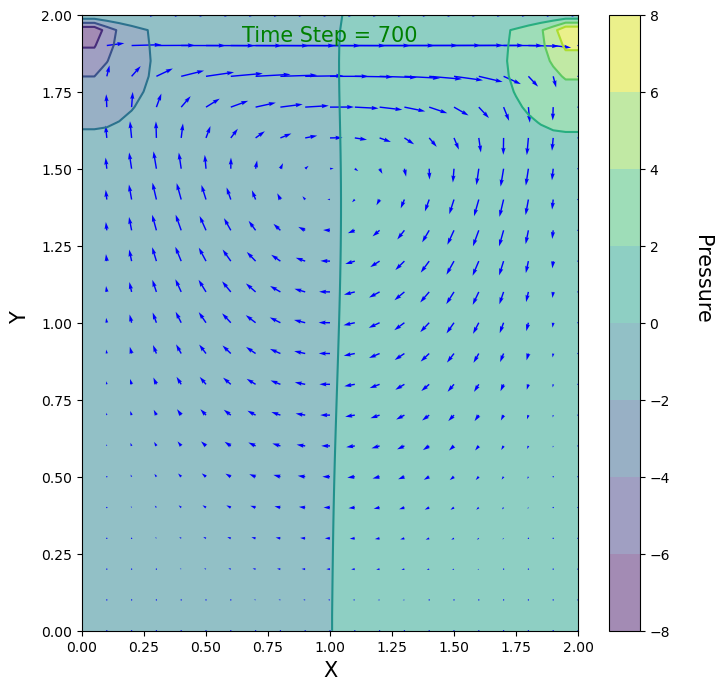

In [19]:
plt.figure(figsize = (8,8))
# plotting the pressure field as a contour
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
plt.colorbar()
#plotting the pressure field outlines
plt.contour(X, Y, p, cmap=cm.viridis)  
# plotting velocity field
plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2], color="blue") 
plt.text(2.5, 1.0, 'Pressure',rotation=-90, ha='center', va='bottom', fontsize=fontsize)
plt.text(-0.25, 1.0, 'Y',rotation=90, ha='center', va='bottom', fontsize=fontsize)
plt.text(1.0, 1.90, 'Time Step = 700',ha='center', va='bottom', fontsize=fontsize, color='green')
plt.xlabel("X", fontsize=fontsize);
#plt.ylabel("Y (m)" , fontsize=fontsize)
plt.savefig("CavityFlow_Solved.pdf", bbox_inches='tight')

It might be interesting to now when we obtain the steady state in terms of velocity. So we compute the velocity at the middle point of the cavity at each time $nt$ and we plot it. First we compute when does the convergenc occur.

In [17]:
eps = 1.0e-05
time_step = np.zeros(nt)
conver_t = 0
conv= 0
for i in range (nt):
    time_step[ i ] = i

for i in range (4, nt-1): #just avoid the first time steps, there a small change between them.
    conv = mid_vel[ i + 1] - mid_vel[ i ]
    if abs(conv) <= eps :
        conver_t = i
        break
print("Convergence time step is: " + str(conver_t))

Convergence time step is: 501


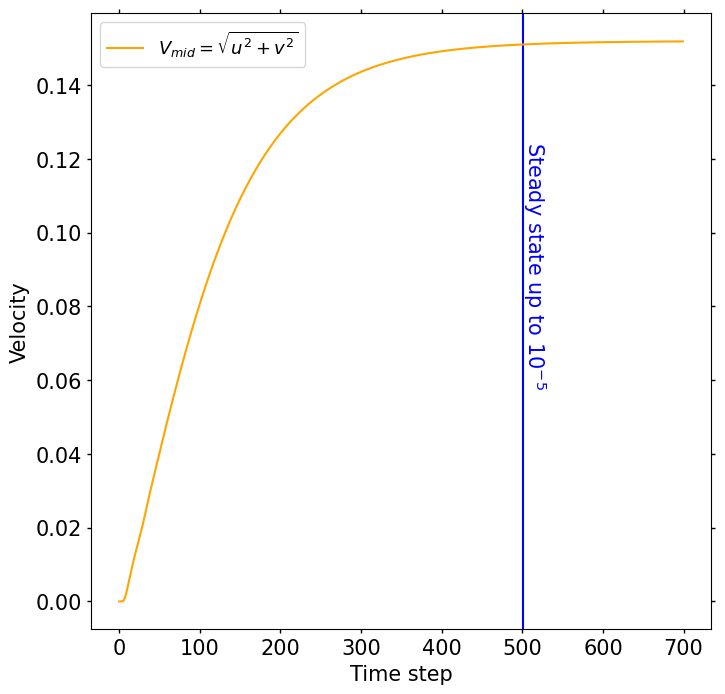

In [20]:

plt.figure(figsize = (8,8))
plt.tick_params(axis='both', which='both',length=3, width=1.0, labelsize=15, right=True, top=True, direction='out')
plt.axvline(x = conver_t, color = 'b')
plt.text(conver_t + 15, mid_vel[int(nt / 10)], 'Steady state up to $10^{-5}$',rotation=-90, ha='center', va='bottom', fontsize=fontsize, color='b')
# plotting the pressure field as a contour
plt.plot(time_step, mid_vel, color="orange", label='$V_{mid}=\sqrt{u^{2} + v^{2}}$')
plt.xlabel("Time step", fontsize=fontsize)
plt.ylabel("Velocity" , fontsize=fontsize)
plt.legend(fontsize=fontsize-2);
plt.savefig("CavityConvergence.pdf", bbox_inches='tight')